In [1]:
#Import Library
from sklearn.ensemble import RandomForestClassifier #use RandomForestRegressor for regression problem
#import os
#import sys
#import json
import itertools
import sklearn
from scipy.stats import norm
from sklearn.metrics import confusion_matrix,roc_curve,auc
from sklearn.metrics import roc_auc_score
import random
import numpy as np
import pandas as pd
import math

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

from sklearn import clone
from sklearn.ensemble import (RandomForestClassifier)

%matplotlib inline  

## load training data

In [2]:
df = pd.read_csv('sc16_combined_all.csv',header=0)
print "data points before eliminating duplicate datapoints:", len(df.index)
df.dropna()
print "size of your training data set:", len(df.index)

# stability threshold; meaning how high does the score have to be to ensure the protein is protease resistant
cutoff = 0.5

# assign stable and unstable to each scaffold as a boolean
df['stable'] = (df.tryp_stability > cutoff)  & (df.chymo_stability > cutoff)
s = df[((df.tryp_stability > cutoff)  & (df.chymo_stability > cutoff))]


print "stable scaffolds in the training data set based on your threshold:" , len(s.index)

data points before eliminating duplicate datapoints: 31595
size of your training data set: 31595
stable scaffolds in the training data set based on your threshold: 6215


## loading independent test data set to evaluate generality 
### (here for comparing prediction with independent data set for which we have experimental confirmation, see Rocklin et al.)
see below at bottom of notebook an example for how to predict stability for your test set

In [3]:
testdata = pd.read_csv('rocklin_combined_scores_21.csv', header=0)
testdata['stable'] = (testdata.stabilityscore_t > cutoff)  & (testdata.stabilityscore_c > cutoff)
testdata.head()

,description,SCORE:,total_score,AlaCount,cavity,contact,contact_per_res,degree2,degreeB,dslf_fa13,...,stabilityscore_t,ec50_c,ec50_95ci_lbound_c,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,ec50_rise_c,stabilityscore_c,stabilityscore,stable
0,EEHEE_rd1_0001_0001,SCORE:,-91.231,5.0,0.000,115.0,2.805,9.780,9.780,0.0,...,0.40,0.93,0.7,1.1,0.4,0.57,0.36,0.17,0.17,False
1,EEHEE_rd1_0002_0001,SCORE:,-93.510,3.0,0.000,133.0,3.244,10.073,10.073,0.0,...,-0.14,1.08,0.5,1.6,1.1,-0.27,1.35,0.65,-0.14,False
2,EEHEE_rd1_0003_0001,SCORE:,-96.460,5.0,0.000,114.0,2.780,10.268,10.268,0.0,...,0.03,1.05,1.0,1.1,0.1,0.91,0.13,0.06,0.03,False
3,EEHEE_rd1_0004_0001,SCORE:,-91.350,4.0,0.000,133.0,3.244,9.780,9.780,0.0,...,0.35,-0.30,-0.5,0.1,0.6,0.37,-0.67,-0.32,-0.32,False
4,EEHEE_rd1_0005_0001,SCORE:,-73.756,4.0,28.312,82.0,2.000,9.390,9.390,0.0,...,-0.44,0.10,0.1,0.1,0.0,2.56,-2.46,-1.18,-1.18,False


## feature overview

In [4]:
# show all columns as a list 
# copy desired parameters to use for prediction. However, even though many are correlated, we oberserved that using
# all together provides a higher accuracy in the predictions

list(testdata)

['description',
 'SCORE:',
 'total_score',
 'AlaCount',
 'cavity',
 'contact',
 'contact_per_res',
 'degree2',
 'degreeB',
 'dslf_fa13',
 'exposed_hydrophobics',
 'fa_atr',
 'fa_atr_per_res',
 'fa_dun_dev',
 'fa_dun_rot',
 'fa_dun_semi',
 'fa_elec',
 'fa_intra_atr_xover4',
 'fa_intra_elec',
 'fa_intra_rep_xover4',
 'fa_intra_sol_xover4',
 'fa_rep',
 'fa_sol',
 'faulty_fragments',
 'hbond_bb_sc',
 'hbond_lr_bb',
 'hbond_sc',
 'hbond_sfn',
 'hbond_sr_bb',
 'holes',
 'hx_sc',
 'hxl_tors',
 'lk_ball',
 'lk_ball_bridge',
 'lk_ball_bridge_uncpl',
 'lk_ball_iso',
 'mean_hbond',
 'np_count',
 'np_res',
 'omega',
 'p_aa_pp',
 'pack',
 'percent_core_SCN',
 'pp_mm',
 'pro_close',
 'rama_prepro',
 'ref',
 'score_per_res',
 'ss_has_core',
 'total_score_cen',
 'unsat_hbond',
 'n_res',
 'dssp',
 'nres_helix',
 'nres_sheet',
 'nres_loop',
 'frac_helix',
 'frac_sheet',
 'frac_loop',
 'hbond_sr_bb_per_helix',
 'hbond_lr_bb_per_sheet',
 'T1_netq',
 'Tminus1_netq',
 'Tend_netq',
 'T1_absq',
 'Tminus1_absq

## feature selection

In [5]:
terms = [
'total_score',
 'AlaCount',
 'cavity',
 'contact',
 'contact_per_res',
 'degreeB',
 'dslf_fa13',
 'exposed_hydrophobics',
 'fa_atr',
 'fa_atr_per_res',
 'fa_dun_dev',
 'fa_dun_rot',
 'fa_dun_semi',
 'fa_elec',
# 'fa_intra_atr_xover4', #using the per residue version below
# 'fa_intra_elec',
# 'fa_intra_rep_xover4',
# 'fa_intra_sol_xover4',
# 'fa_rep',
# 'fa_sol',
 'hbond_bb_sc',
 'hbond_lr_bb',
 'hbond_sc',
 'hbond_sfn',
 'hbond_sr_bb',
 'holes',
 'hx_sc',
 'hxl_tors',
 'lk_ball',
 'lk_ball_bridge',
 'lk_ball_bridge_uncpl',
 'lk_ball_iso',
 'mean_hbond',
 'np_count',
 'np_res',
# 'omega',
 'p_aa_pp',
 'pack',
 'percent_core_SCN',
 'pp_mm',
 'pro_close',
 'rama_prepro',
 'ref',
 'score_per_res',
 'total_score_cen',
 'unsat_hbond',
 'buried_np',
 'exposed_np',
 #'buried_np_AFILMVWY',
 #'exposed_np_AFILMVWY',
 'n_res',
 'buried_np_AFILMVWY_per_res',
 'nres_helix',
 'nres_sheet',
 'nres_loop',
 'hbond_sr_bb_per_helix',
 'hbond_lr_bb_per_sheet',
 'worstfrag',
 'worst6frags',
 'sum_best_frags',
 'avg_all_frags',
 'avg_best_frag',
 'abego_res_profile',
 'abego_res_profile_penalty',
 'largest_hphob_cluster',
 'n_hphob_clusters',
 'hphob_sc_contacts',
 'hphob_sc_degree',
 'most_conRE',
 'most_conREn',
 'graph_density',
 'bad_hub_penalty',
 'highly_conREsum',
 'highly_conREsum_pres',
 'highly_conREsumNorm',
 'highly_conREsumNorm_pres',
 'avgE_top_conResidues',
 'avgE_top_conResiduesNorm',
 'avg_con',
 'median_con',
 'max_con',
 'num_bad_res',

 'n_charged',
 'n_hydrophobic',
 'n_hydrophobic_noA',
 'hydrophobicity',
 'contig_not_hp_max',
 'contig_not_hp_internal_max',
 'contig_not_hp_avg',
 'contig_not_hp_avg_norm',
 'fa_rep_per_res',
 'net_atr_per_res',
 'net_sol_per_res',
 'net_atr_net_sol_per_res',
 'buried_np_per_res',
 'exposed_np_per_res',
 'buried_minus_exposed_per_res',
 'fa_intra_atr_xover4_per_res',
 'fa_intra_rep_xover4_per_res',
 'fa_intra_sol_xover4_per_res',
    

]

# drop duplicates
predict_term = "stable"
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(axis=0)
print len(df.index)

31184


In [6]:
testdata[terms].head()

,total_score,AlaCount,cavity,contact,contact_per_res,degreeB,dslf_fa13,exposed_hydrophobics,fa_atr,fa_atr_per_res,...,fa_rep_per_res,net_atr_per_res,net_sol_per_res,net_atr_net_sol_per_res,buried_np_per_res,exposed_np_per_res,buried_minus_exposed_per_res,fa_intra_atr_xover4_per_res,fa_intra_rep_xover4_per_res,fa_intra_sol_xover4_per_res
0,-91.231,5.0,0.000,115.0,2.805,9.780,0.0,218.248,-200.890,-4.899756,...,0.591341,-4.308415,1.732561,-2.575854,98.673222,5.323122,93.350100,-0.299317,0.115220,0.208537
1,-93.510,3.0,0.000,133.0,3.244,10.073,0.0,166.309,-212.862,-5.191756,...,0.710195,-4.481561,2.040976,-2.440585,101.389962,4.056317,97.333645,-0.360585,0.171000,0.339878
2,-96.460,5.0,0.000,114.0,2.780,10.268,0.0,313.510,-207.885,-5.070366,...,0.613512,-4.456854,1.890683,-2.566171,100.447810,7.646585,92.801225,-0.323049,0.127268,0.252927
3,-91.350,4.0,0.000,133.0,3.244,9.780,0.0,226.452,-210.566,-5.135756,...,0.524878,-4.610878,2.055024,-2.555854,98.587282,5.523220,93.064062,-0.372146,0.130244,0.265659
4,-73.756,4.0,28.312,82.0,2.000,9.390,0.0,70.313,-184.148,-4.491415,...,0.484146,-4.007268,1.901317,-2.105951,92.468728,1.714951,90.753777,-0.306732,0.148098,0.262878


In [ ]:
# keep 15% of the data back to monitor ROC and AUC
def train1_predict2_get_auc_featurelist(df1,df2,terms,getROC,title):
    all_indices = list(range(len(df1)))
    test_indices = random.sample(range(len(df1)), int(len(df1)*0.15))
    print "training set", len(df1)
    print "test the trained model", len(test_indices)
    print "testing new subset:", len(df2)
    
    if getROC == True:
        print " getting FP and TP"
        
    use_indices = list(set(all_indices) - set(test_indices))

    test_df = df1.iloc[test_indices]
    use_df = df1.iloc[use_indices]

    train_data = use_df[terms]
    train_val = use_df['stable']

    test_data = test_df[terms]
    test_val = test_df['stable']

    info_test = df1.iloc[test_indices]
    info_test.head()

    clf = RandomForestClassifier()
    clf = RandomForestClassifier(n_jobs=-1,n_estimators=500, oob_score=True)#,random_state=0)
    clf.fit(train_data[terms], train_val)
    prediced = clf.predict(test_data[terms])

    test_prob = clf.predict_proba(test_data)
    test_preds = test_prob[:,1]

    feature_importance = clf.feature_importances_
    features_list = df1[terms].columns.values[::]
      
    df2_val = df2.stable

    predict2 = clf.predict(df2[terms])
    test_prob2 = clf.predict_proba(df2[terms])
    test_preds2 = test_prob2[:,1]

    try:
        #auc  = roc_auc_score(test_val, test_preds)
        auc = roc_auc_score(test_val,test_preds)
        acc = accuracy_score(test_val, prediced)

    except:
        print "exception, no AUC or ACC computed"
        auc = 0 
        acc = 0

    
    try:
        auc2= roc_auc_score(df2_val,test_preds2)
        acc2 = accuracy_score(df2_val,predict2)
        
    except:
        auc2 = 0
        acc2 = 0

    fpr2,tpr2,thresholds2 = roc_curve(df2_val, test_preds2)

    print "re-tested training model AUC %.3f" % roc_auc_score(test_val,test_preds)
    print "AUC %.3f" % roc_auc_score(df2_val, test_preds2)
    
    return feature_importance,auc,auc2,acc,acc2,fpr2,tpr2


31184
4677
26507
Train Accuracy ::  1.0
AUC :: 0.902112189793058


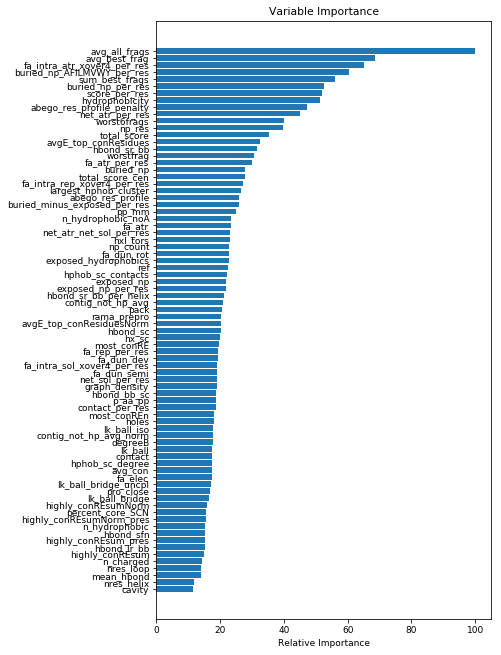

In [8]:
all_indices = list(range(len(df)))
test_indices = random.sample(range(len(df)), int(len(df)*0.15))

print "training data points: ", len(all_indices)
print "15% of the data to evaluate predictive power: ", len(test_indices)

use_indices = list(set(all_indices) - set(test_indices))
print len(use_indices)

test_df = df.iloc[test_indices]
use_df = df.iloc[use_indices]

train_data = use_df[terms]
train_val = use_df['stable']

test_data = test_df[terms]
test_val = test_df['stable']

info_test = df.iloc[test_indices]
info_test.head()

clf = RandomForestClassifier(n_jobs=-1,n_estimators=500, oob_score=True)#,random_state=0)
clf.fit(train_data[terms], train_val)
prediced = clf.predict(test_data[terms])


print "Train Accuracy :: ", accuracy_score(train_val, clf.predict(train_data))
#print "Test Accuracy  :: ", accuracy_score(test_val, prediced)

feature_importance = clf.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

# A threshold below which to drop features from the final data set. Specifically, this number represents
# the percentage of the most important feature's importance value
fi_threshold = 10

# Get the indexes of all features over the importance threshold  #&(feature_importance < 90)
important_idx = np.where((feature_importance > fi_threshold) )[0]

#features_list = params
features_list = df[terms].columns.values[::]
# Create a list of all the feature names above the importance threshold
important_features = features_list[important_idx]

# Get the sorted indexes of important features
sorted_idx = np.argsort(feature_importance[important_idx])[::-1]

# Adapted from http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
pos = np.arange(sorted_idx.shape[0]) + .5
#plt.subplot(1, 2, 2)
plt.rc('font',size=9)
plt.subplots(figsize=(6, 11))
plt.barh(pos, feature_importance[important_idx][sorted_idx[::-1]], align='center')
plt.yticks(pos, important_features[sorted_idx[::-1]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')


#####

test_prob = clf.predict_proba(test_data)
test_preds = test_prob[:,1]

fpr1,tpr1,thresholds1 = roc_curve(test_val, test_preds)

auc = roc_auc_score(test_val,test_preds)

print "AUC ::", auc

#plt.show()
#plt.clf()


#plt.title('Receiver Operating Characteristic ')



#plt.figure(figsize=(2,3))
#plt.rc('font',size=20)
#sns.boxplot(auc,orient='v')
#plt.show()

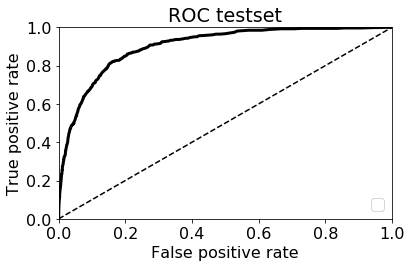

In [9]:
plt.rc('font',size=16)
fig, ax = plt.subplots()
plt.title('ROC testset')
plt.plot(fpr1, tpr1, 'black', linewidth=3)# label = "all"

plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


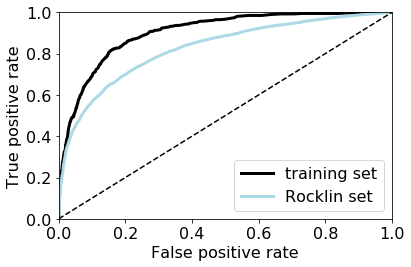

AUC :: 0.83


In [67]:
predicted = clf.predict(testdata[terms])

test_proba = clf.predict_proba(testdata[terms])
test_predi = test_proba[:,1]

testdata_val = testdata.stable

auc  = roc_auc_score(testdata_val, test_predi)
acc = accuracy_score(testdata_val, predicted)

fpr_testdata,tpr_testdata,thresholds_testdata = roc_curve(testdata_val, test_predi)

plt.plot(fpr1, tpr1, 'black', label = "training set",linewidth=3)
plt.plot(fpr_testdata, tpr_testdata, 'lightblue', label = "Rocklin set",linewidth=3)
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

print "AUC :: %.2f" % auc 


## example case how to predict stability for your data set

In [34]:
filename = 'rocklin_as_example_case.csv'
set1 = pd.read_csv(filename)

set1 = set1.set_index('description')
set1.head()



,SCORE:,total_score,AlaCount,cavity,contact,contact_per_res,degree2,degreeB,dslf_fa13,exposed_hydrophobics,...,highly_conREsum_pres,highly_conREsumNorm,highly_conREsumNorm_pres,avgE_top_conResidues,avgE_top_conResiduesNorm,avg_con,median_con,max_con,num_bad_res,name
description,,,,,,,,,,,,,,,,,,,,,
EEHEE_rd1_0001_0001,SCORE:,-91.231,5,0.000,115,2.805,9.780,9.780,0,218.248,...,-0.124000,-0.847336,-0.020667,-2.095362,-0.941228,2.810811,3.0,6,4,EEHEE_rd1_0001.pdb
HHH_rd3_0246_0001,SCORE:,-117.926,6,10.279,129,3.000,10.674,10.674,0,191.647,...,-0.559111,-3.729175,-0.086725,-2.768035,-0.790931,3.488372,3.0,7,4,HHH_rd3_0246.pdb
HHH_rd3_0247_0001,SCORE:,-96.116,4,0.000,127,2.953,10.163,10.163,0,242.571,...,-0.152029,-0.968279,-0.022518,-2.434782,-0.648175,3.627907,3.0,7,4,HHH_rd3_0247.pdb
HHH_rd3_0247_0001,SCORE:,-96.116,4,0.000,127,2.953,10.163,10.163,0,242.571,...,-0.152029,-0.968279,-0.022518,-2.434782,-0.648175,3.627907,3.0,7,4,HHH_rd3_0247.pdb
HHH_rd3_0248_0001,SCORE:,-114.516,6,10.279,101,2.349,10.628,10.628,0,83.485,...,-0.610710,-4.287803,-0.099716,-2.690680,-0.878594,3.418605,3.0,7,0,HHH_rd3_0248.pdb


In [35]:
predict_set1 = clf.predict(set1[terms])
predict_set1

array([False, False, False, ..., False, False,  True])

In [66]:
# summary for prediction
p = len(set1[predict_set1])
start = len(set1) *1.0
print "data points in your set: \t" , int(start)
print "designs predicted as folded: \t", p
print "this means you have:   \t\t%.2f " % (p/start*100) , "% predicted success rate"

cut = set1[predict_set1]
cut.to_csv('prediction_' + filename)
print
print "saving predicted to be stable designs to to prediction_" + filename

data points in your set: 	1001
designs predicted as folded: 	686
this means you have:   		68.53  % predicted success rate

saving predicted to be stable designs to to prediction_rocklin_as_example_case.csv


#### 